In [23]:
### Binary classification -> Neural networks.
###classifying circles

In [24]:
##dependencies
from sklearn.datasets import make_circles #generate circles
import pandas as pd ##creating data frame
import matplotlib.pyplot as plt ##for drawing plots
import torch #creating tensors
from torch import nn ## basic building block of neural networks

In [25]:
## make   1000 samples 
n_samples = 1000
x, y = make_circles(
    n_samples,
    noise=0.02,
    random_state=30
)

In [26]:
## visualizing my data
##dataframe
circles = pd.DataFrame({
    'X1': x[:, 0], 
    'X2': x[:, 1],
    'Labels': y
})

circles.head(10)
##circles['Labels'].value_counts()

X1        X2  Labels
0  0.471109 -0.688698       1
1  0.470924 -0.657534       1
2  0.757632  0.133427       1
3  0.441729  0.914881       0
4  0.064846 -0.799789       1
5  0.913613 -0.459859       0
6  0.182394  0.992764       0
7 -0.799707 -0.551241       0
8  0.488100 -0.869731       0
9 -0.357087  0.743005       1

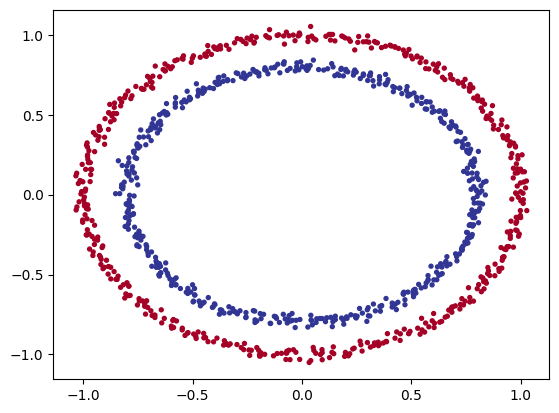

In [27]:
### drawing plots
plt.scatter(
    x=x[:,0],
    y=x[:,1],
    s=8,
    c=y,
    cmap=plt.cm.RdYlBu
)
plt.show()

In [28]:
##turn data into training and testing data
###input and output shapes 
##x.shape, y.shape

x_tensor = torch.from_numpy(x).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

#x_tensor.shape, y_tensor.shape
#x_tensor, y_tensor

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    x_tensor,
    y_tensor, 
    test_size=0.2, #20% test data, 80% training data
    random_state=30
)

print(f"X training data: {len(X_train)}\nX Test Data: {len(X_test)}\n Y_train Data: {len(Y_train)}\n Y Test DATA: {len(Y_test)}")

X training data: 800
X Test Data: 200
 Y_train Data: 800
 Y Test DATA: 200


In [29]:
##device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [30]:
### create a model
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), #2 inputs (x) with 1 hidden layer (5 neurons)
    nn.Linear(in_features=5, out_features=1) #1 output y
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(Y_test)}, Shape: {Y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{Y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.5725],
        [-0.2777],
        [-0.6568],
        [-0.3121],
        [-0.2582],
        [-0.7504],
        [-0.5968],
        [-0.4197],
        [-0.2621],
        [-0.4448]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 0.])


In [32]:
##loss function and optimizer
#loss_fn = torch.nn.BCELoss() # no sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss() #sigmoid built in

#optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

#function to calculate accuracy of model
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() #find number of correct predictions
    acc = (correct/len(y_pred))*100
    return acc

In [34]:
##logits are unnormalized final scores of your model -> source: data science stack exchange
##training and testing our model

torch.manual_seed(40)

epochs = 300 #train with 100 epochs 

#put train data and test data to device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

#training loop

for epoch in range(epochs):
    model_0.train() #training mode

    #forward pass
    y_logits = model_0(X_train).squeeze() #squeeze to remove extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) #normalize using sigmoid fxn -> round to get prediction probabalities using round

    #calculate the loss
    loss = loss_fn(y_logits, Y_train) #not using sigmoid since BCEWithLogitsLoss has inbuilt sigmoid 

    acc = accuracy_fn(y_true=Y_train, 
    y_pred=y_pred)

    #optimizer zero grad
    optimizer.zero_grad()

    #loss backwards 
    loss.backward()

    #optmizer step -> apply gradient descent
    optimizer.step()

    ###testing 
    model_0.eval()
    with torch.inference_mode():
        #inference
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        #calculate test loss
        test_loss = loss_fn(test_logits, Y_test) 

        #test accuracy
        test_acc = accuracy_fn(
            y_true=Y_test,
            y_pred=test_pred
        )

    #print out whats happening 
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} ~ Loss: {loss:.5f}, Accuracy: {acc:.2f} ~ Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")

Epoch: 0 ~ Loss: 0.69315, Accuracy: 51.50 ~ Test Loss: 0.69517, Test Accuracy: 50.00
Epoch: 10 ~ Loss: 0.69312, Accuracy: 51.25 ~ Test Loss: 0.69507, Test Accuracy: 50.00
Epoch: 20 ~ Loss: 0.69310, Accuracy: 51.12 ~ Test Loss: 0.69497, Test Accuracy: 50.50
Epoch: 30 ~ Loss: 0.69309, Accuracy: 51.38 ~ Test Loss: 0.69488, Test Accuracy: 50.50
Epoch: 40 ~ Loss: 0.69307, Accuracy: 51.50 ~ Test Loss: 0.69480, Test Accuracy: 51.00
Epoch: 50 ~ Loss: 0.69306, Accuracy: 51.50 ~ Test Loss: 0.69473, Test Accuracy: 50.50
Epoch: 60 ~ Loss: 0.69306, Accuracy: 51.62 ~ Test Loss: 0.69467, Test Accuracy: 51.50
Epoch: 70 ~ Loss: 0.69305, Accuracy: 51.62 ~ Test Loss: 0.69462, Test Accuracy: 51.00
Epoch: 80 ~ Loss: 0.69305, Accuracy: 51.25 ~ Test Loss: 0.69457, Test Accuracy: 51.00
Epoch: 90 ~ Loss: 0.69304, Accuracy: 51.38 ~ Test Loss: 0.69453, Test Accuracy: 51.00
Epoch: 100 ~ Loss: 0.69304, Accuracy: 51.75 ~ Test Loss: 0.69449, Test Accuracy: 51.00
Epoch: 110 ~ Loss: 0.69304, Accuracy: 51.75 ~ Test Los